In [1]:
import sklearn as sk
import xgboost as xgb
import numpy as np
import pandas as pds
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC

In [3]:
# Load in the train and test datasets
train = pd.read_csv('/content/titanic_train.csv')
test = pd.read_csv('/content/titanic_test.csv')

train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
# Applying the pipline on training/testing data
full_dataset = [train, test]

In [5]:
# Some features that can be created from the Name column

# Name Length
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Featurizing titles from names using Regular Expression
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_dataset:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in full_dataset:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [6]:
# Making the column a boolean one 
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [7]:
# FamilySize can be the sum of SibSp and Parch + 1
for dataset in full_dataset:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Adding anther column for passengers travelling along
for dataset in full_dataset:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [8]:
# Column: Embarked
for dataset in full_dataset:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Column: Fare 
for dataset in full_dataset:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

In [9]:
# Column: Fare
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [10]:
# Making Age column a categorical
for dataset in full_dataset:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
 # Columns: Titles, sex, embarked, Fare, Age
for dataset in full_dataset:
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;
    
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int) 
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [12]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [13]:
# Model Class to be used for different ML algorithms
class ClassifierModel(object):
    def __init__(self, clf, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
    def predict(self, x):
        return self.clf.predict(x)

In [14]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [15]:
def trainModel(model, x_train, y_train, x_test, n_folds, seed):
    cv = KFold(n_splits= n_folds)
    scores = cross_val_score(model.clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    y_pred = cross_val_predict(model.clf, x_train, y_train, cv=cv, n_jobs=-1)
    return scores, y_pred

In [16]:
# Random Forest parameters
rf_params = {
    'n_estimators': 400,
    'max_depth': 5,
    'min_samples_leaf': 3,
    'max_features' : 'sqrt',
}
rfc_model = ClassifierModel(clf=RandomForestClassifier, params=rf_params)
rfc_scores, rfc_train_pred = trainModel(rfc_model,x_train, y_train, x_test, 5, 0) # Random Forest
rfc_scores

array([0.82122905, 0.82022472, 0.80898876, 0.79775281, 0.85955056])

In [17]:
# Getting features importance 
rfc_features = rfc_model.feature_importances(x_train,y_train)
rfc_features

array([0.11037508, 0.22787457, 0.02681788, 0.01553139, 0.04519484,
       0.01767339, 0.08812638, 0.32677546, 0.06586931, 0.06735127,
       0.00841042])

In [18]:
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':400,
    'max_depth': 5,
    'min_samples_leaf': 2,
}
etc_model = ClassifierModel(clf=ExtraTreesClassifier, params=et_params)
etc_scores, etc_train_pred = trainModel(etc_model,x_train, y_train, x_test, 5, 0) # Random Forest
etc_scores

array([0.83798883, 0.80898876, 0.82022472, 0.7752809 , 0.85955056])

In [19]:
# Getting features importance 
etc_features = etc_model.feature_importances(x_train, y_train)
etc_features

array([0.12391277, 0.40272859, 0.01719639, 0.00924251, 0.0467215 ,
       0.01812471, 0.03368196, 0.19909066, 0.09727193, 0.02909735,
       0.02293163])

In [20]:
# AdaBoost parameters
ada_params = {
    'n_estimators': 400,
    'learning_rate' : 0.65
}
ada_model = ClassifierModel(clf=AdaBoostClassifier, params=ada_params)
ada_scores, ada_train_pred = trainModel(ada_model,x_train, y_train, x_test, 5, 0) # Random Forest
ada_scores

array([0.83240223, 0.78651685, 0.81460674, 0.81460674, 0.83707865])

In [21]:
# Getting features importance 
ada_features = ada_model.feature_importances(x_train, y_train)
ada_features

array([0.035 , 0.0125, 0.0225, 0.0725, 0.0375, 0.0125, 0.6475, 0.0875,
       0.01  , 0.06  , 0.0025])

In [22]:
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 400,
    'max_depth': 6,
}
gbc_model = ClassifierModel(clf=GradientBoostingClassifier, params=gb_params)
gbc_scores, gbc_train_pred = trainModel(gbc_model,x_train, y_train, x_test, 5, 0) # Random Forest
gbc_scores

array([0.7877095 , 0.78651685, 0.80337079, 0.78089888, 0.85393258])

In [23]:
# Getting features importance 
gbc_features = gbc_model.feature_importances(x_train,y_train)
gbc_features 

array([0.07990964, 0.00926682, 0.05863897, 0.01649311, 0.05213912,
       0.03419899, 0.18027313, 0.40469206, 0.03837947, 0.11576471,
       0.01024399])

In [24]:
# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }
svc_model = ClassifierModel(clf=SVC, params=svc_params)
svc_scores, svc_train_pred = trainModel(svc_model,x_train, y_train, x_test, 5, 0) # Random Forest
svc_scores

array([0.83240223, 0.80898876, 0.82022472, 0.7752809 , 0.83707865])

In [25]:
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': train.columns.values,
    'Random Forest feature importances': rfc_features,
    'Extra Trees  feature importances': etc_features,
    'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gbc_features
    })

In [26]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.110375,0.123913,0.0350,0.079910,0.087299
1,Sex,0.227875,0.402729,0.0125,0.009267,0.163092
2,Age,0.026818,0.017196,0.0225,0.058639,0.031288
3,Parch,0.015531,0.009243,0.0725,0.016493,0.028442
4,Fare,0.045195,0.046721,0.0375,0.052139,0.045389
5,Embarked,0.017673,0.018125,0.0125,0.034199,0.020624
6,Name_length,0.088126,0.033682,0.6475,0.180273,0.237395
7,Title,0.326775,0.199091,0.0875,0.404692,0.254515
8,Has_Cabin,0.065869,0.097272,0.0100,0.038379,0.052880
9,FamilySize,0.067351,0.029097,0.0600,0.115765,0.068053


In [27]:
acc_pred_train = pd.DataFrame ({'RandomForest': rfc_scores.ravel(),
     'ExtraTrees': etc_scores.ravel(),
     'AdaBoost': ada_scores.ravel(),
      'GradientBoost': gbc_scores.ravel()
    })
acc_pred_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.821229,0.837989,0.832402,0.787709
1,0.820225,0.808989,0.786517,0.786517
2,0.808989,0.820225,0.814607,0.803371
3,0.797753,0.775281,0.814607,0.780899
4,0.859551,0.859551,0.837079,0.853933


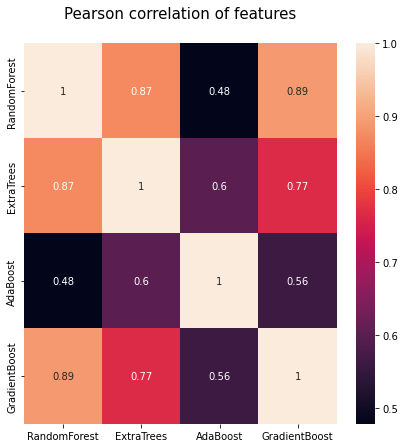

In [28]:
colormap = plt.cm.RdBu
plt.figure(figsize=(7,7))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(acc_pred_train.astype(float).corr(), annot=True);

In [29]:
x_train = np.column_stack(( etc_train_pred, rfc_train_pred, ada_train_pred, gbc_train_pred, svc_train_pred))

In [30]:
x_train.shape

(891, 5)

In [31]:
acc_pred_train

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.821229,0.837989,0.832402,0.787709
1,0.820225,0.808989,0.786517,0.786517
2,0.808989,0.820225,0.814607,0.803371
3,0.797753,0.775281,0.814607,0.780899
4,0.859551,0.859551,0.837079,0.853933


In [32]:
def trainStackModel(x_train, y_train, x_test, n_folds, seed):
    cv = KFold(n_splits= n_folds)
    gbm = xgb.XGBClassifier(
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     scale_pos_weight=1).fit(x_train, y_train)
    
    scores = cross_val_score(gbm, x_train, y_train, scoring='accuracy', cv=cv)
    return scores

In [33]:
stackModel_scores = trainStackModel(x_train, y_train, x_test, 5, 0)

In [34]:
acc_pred_train['stackingModel'] = stackModel_scores
acc_pred_train

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,stackingModel
0,0.821229,0.837989,0.832402,0.787709,0.837989
1,0.820225,0.808989,0.786517,0.786517,0.825843
2,0.808989,0.820225,0.814607,0.803371,0.837079
3,0.797753,0.775281,0.814607,0.780899,0.780899
4,0.859551,0.859551,0.837079,0.853933,0.853933
